
## Analytic Solutions

Underworld provides a set of analytic solutions to Stokes flow problems.

In this example, analytic solution objects are used to configure the analogous numerical system, with the numerical solution then compared to the exact. 

<table><tr><td><img src='./images/err_fig_vel.png' height="400" width="470"></td><td><img src='./images/err_fig_press.png' height="400" width="470"></td></tr></table>

In [1]:
# Solution to view:
view_soln   = "SolCx"
view_order  = 2
view_res    = 32
view_params = { "n_z":1, "eta_B":100000.0 }

In [2]:
import underworld as uw
import glucifer
from underworld import function as fn
import math
import numpy as np
import collections

uw.matplotlib_inline()

In [3]:
# Find all available 2D solutions. 
# Use ordered dict to preserve alphabetical ordering
solns_avail = collections.OrderedDict()
for soln_name in dir(fn.analytic):
    if soln_name[0] == "_": continue  # if private member, ignore
    # get soln class
    soln = getattr(fn.analytic,soln_name)
    # check if actually soln
    if issubclass(soln, fn.analytic._SolBase):
        # construct
        print("Solution added: {}".format(soln_name))
        solns_avail[soln_name] = soln

Solution added: SolA
Solution added: SolB
Solution added: SolC
Solution added: SolCx
Solution added: SolDA
Solution added: SolDB2d
Solution added: SolDB3d
Solution added: SolH
Solution added: SolKx
Solution added: SolKz
Solution added: SolM
Solution added: SolNL


In [4]:
def get_numerical( soln, res=32, order=1, itol=1.e-8, otol=1.e-8 ):
    '''
    Creates the numerical system corresponding to the provided analytic system.
    
    Parameters
    ----------
    soln : uw.function.analytic._SolBase
        The analytic system
    res : int
        System resolution. Same resolution is used for each axis.
    order : int
        System numerical order. 
    itol : float
        Inner solve tolerance.
    otol : float
        Outer solve tolerance.

    '''
    if order == 1:
        els = "Q1/dQ0"
    elif order == 2:
        els = "Q2/dPc1"
    else:
        raise ValueError("Provided system order should be 1 or 2.")

    dim = soln.dim
    mesh  = uw.mesh.FeMesh_Cartesian(elementType=els, elementRes=(res,)*dim,minCoord=(0.,)*dim,maxCoord=(1.,)*dim)
    vel   = uw.mesh.MeshVariable(mesh,dim)
    press = uw.mesh.MeshVariable(mesh.subMesh, 1)
    vel.data[:]   = (0.,)*dim
    press.data[:] = 0.

    bcs = soln.get_bcs(vel)
    
    stokes = uw.systems.Stokes(vel,press,soln.fn_viscosity,fn_bodyforce=soln.fn_bodyforce, conditions=[bcs,])
    solver = uw.systems.Solver(stokes)
    if uw.mpi.size==1:
        solver.set_inner_method("lu")
    solver.set_inner_rtol(itol)
    solver.set_outer_rtol(otol)

    return mesh, vel, press, stokes, solver

def calibrate_press(press, press_analytic):
    '''
    Numerical pressure is only provided up to an arbitrary
    constant. This function returns a calibrated version
    of the numerical solution to allow useful comparisons.
    '''
    # note we really should do this on root proc, then broadcast offset
    offset = press.data[0] - press_analytic.evaluate(press.mesh.data[0:1])
    return press - offset[0]

Go ahead and create the numerical system analogue

In [5]:
soln = solns_avail[view_soln](**view_params)
mesh, vel, press, system, solver = get_numerical( soln, order=view_order, res=view_res )

In [6]:
# create figure for bodyforce
viz_args = {}
if soln.dim == 3:
    viz_args["crossSection"]='y=0.5'

bf_mag = fn.math.sqrt(fn.math.dot(soln.fn_bodyforce,soln.fn_bodyforce))
fig_bodyforce = glucifer.Figure(figsize=(500,570), background="white", margin="1", title="Body Force")
fig_bodyforce.append(glucifer.objects.Surface(mesh,bf_mag,colours="polar",**viz_args))
fig_bodyforce.append(glucifer.objects.VectorArrows(mesh,soln.fn_bodyforce,**viz_args))

In [7]:
# also figure for viscosity
fig_viscosity = glucifer.Figure(figsize=(500,570), background="white", margin="1", title="Viscosity")
fig_viscosity.append(
    glucifer.objects.Surface(mesh,soln.fn_viscosity,colours="spectral", logscale=False, onMesh=False, **viz_args ))

The body force and viscosity form inputs to the numerical system

,

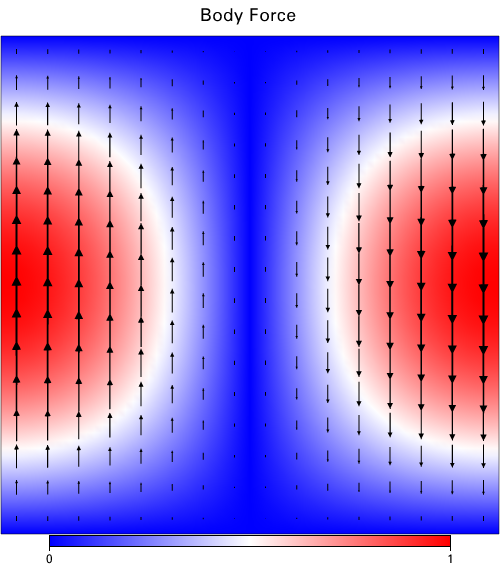
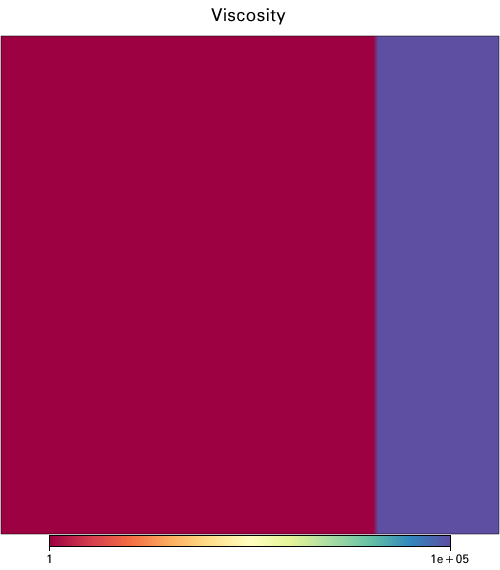

In [8]:
glucifer.Figure.show_grid((fig_bodyforce,fig_viscosity))

In [9]:
# generate our numerical solution
solver.solve()

In [10]:
# create figure for the velocity solution
fig_velocity = glucifer.Figure(figsize=(500,570), background="white", margin="1", title="Velocity")
vel_mag = fn.math.sqrt(fn.math.dot(vel,vel))
fig_velocity.append(glucifer.objects.Surface(mesh,vel_mag,colours=['white',"darkblue"],**viz_args))
fig_velocity.append(glucifer.objects.VectorArrows(mesh,vel,**viz_args))

In [11]:
# numerical pressure is only defined up to a constant, so offset to match analytic
press = calibrate_press(press, soln.fn_pressure) 

In [12]:
# create figure for the pressure solution
fig_pressure = glucifer.Figure(figsize=(500,570), background="white", margin="1", title="Pressure")
fig_pressure.append(glucifer.objects.Surface(mesh,press,colours=['white',"darkred"],onMesh=False,**viz_args))

,

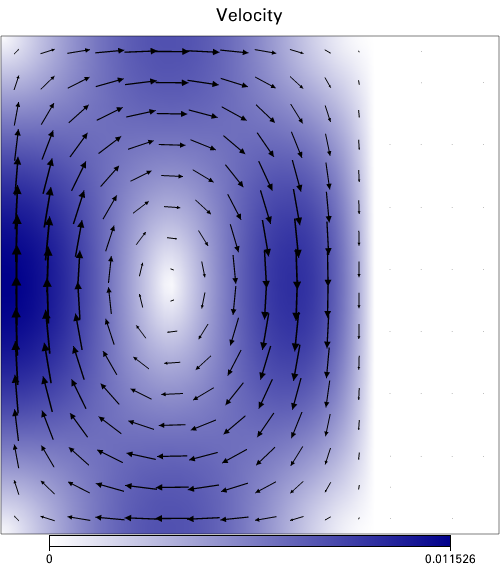
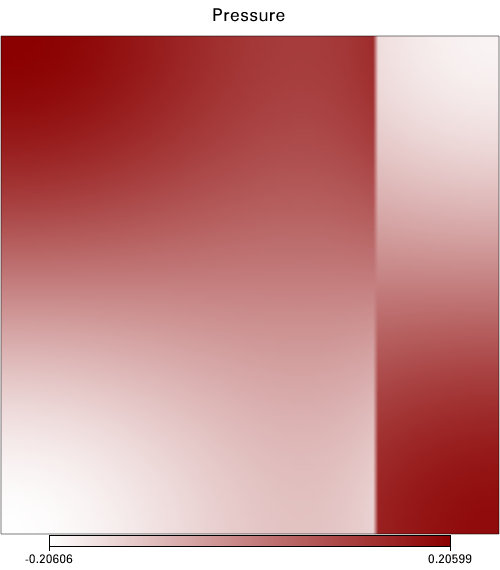

In [13]:
glucifer.Figure.show_grid((fig_velocity,fig_pressure))

,

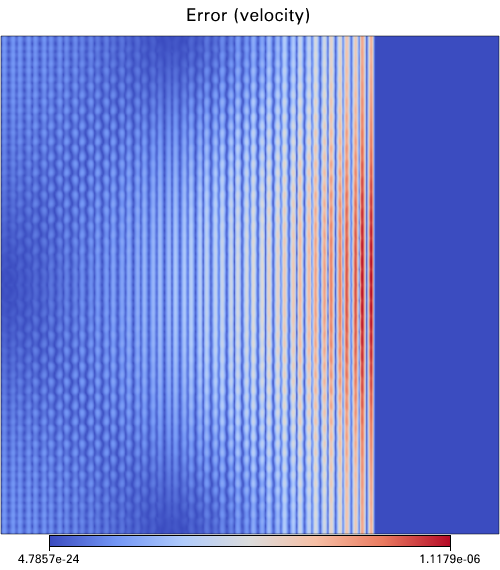
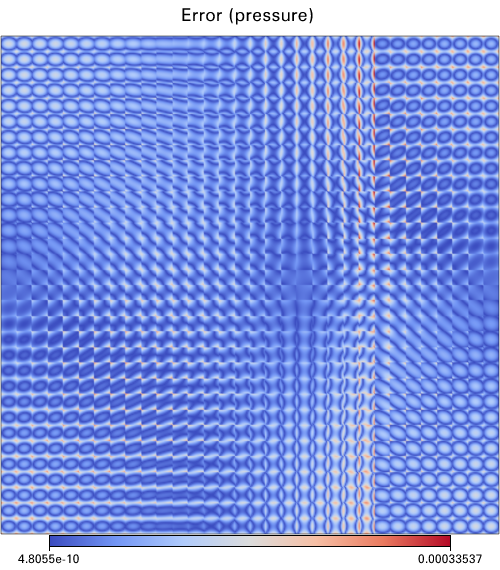

In [14]:
# Visualise the error field
def fn_error(numeric, analytic):
    '''
    Returns absolute error Function objects.
    '''
    delta        = analytic - numeric
    absolute_err = fn.math.sqrt(fn.math.dot(delta,delta))

    return absolute_err 

abserr = fn_error(vel,soln.fn_velocity)
err_fig_vel = glucifer.Figure(figsize=(500,570), margin="1", title="Error (velocity)")
err_fig_vel.append(glucifer.objects.Surface(mesh, abserr, logscale=False, colours="coolwarm", onMesh=False, resolution=400, **viz_args))

abserr = fn_error(press,soln.fn_pressure)
err_fig_press = glucifer.Figure(figsize=(500,570), margin="1", title="Error (pressure)")
err_fig_press.append(glucifer.objects.Surface(mesh, abserr, logscale=False, colours="coolwarm", onMesh=False, resolution=400, **viz_args))

glucifer.Figure.show_grid((err_fig_vel,err_fig_press))

In [15]:
# Check VRMS for the standard config.
if (view_soln   == "SolCx") and \
   (view_order  == 2)       and \
   (view_res    == 32)      and \
   (view_params == { "n_z":1, "eta_B":100000.0 }):
    if not np.isclose(system.velocity_rms(),0.005578279626793198,rtol=1e-7):
        raise RuntimeError("Solution VRMS not as expected.")
else:
    import warnings
    warnings.warn("Not testing for correct results.")